# Introduction
In my [previous blog post](https://www.feststelltaste.de/spotting-co-changing-files/), we've seen how we can identify files that change together in one commit.

In this blog post, we take the analysis to an advanced level:

* We're using a more robust model for determining the similarity of co-changing source code
* We're creating a visualization that let us (to a certain degree) determine the underlying modularization of our software system based on the conjoint changes
* We discuss the result for a concrete software system in detail (with more to come in the upcoming blog posts).

We're using [Python](https://www.python.org/) and [pandas](https://pandas.pydata.org/) as well as some algorithms from [scikit-learn](http://scikit-learn.org/) and the visualization libraries [matplotlib](https://matplotlib.org/) and [pygal](http://www.pygal.org/) for these purposes.

# Idea

For this analysis, we use a former project of me and some buddys of mine. It's called "DropOver", a web application that can manage events with features like events' sites, scheduling, comments, todos, file uploads and so on. The architecture of the software system mirrored the feature-based approach of the development: You could quickly locate where code for a feature has to be changed because the software system's "screaming architecture" would lead you right to the spot because of the explicit, feature-based modularization:

![](resources/dropover_package_structure.png)

Albeit I can't share the repository yet, you have to know that we developed the software almost strictly feature-based by feature teams (OK, one developer was one team).

The history of this repository should perfectly fit for our analysis of checking the modularization based on co-changing source code. We wanna see if "teams" can work withing modules independently of if they are changing code randomly. 

# Analysis
We use a [little helper library](https://github.com/feststelltaste/software-analytics/blob/master/notebooks/lib/ozapfdis/git_tc.py) for the importing the data of our project. It's a simple git log with change statistics for each file and commit ([you can see here how to retrieve it](https://www.feststelltaste.de/reading-a-git-repos-commit-history-with-pandas-efficiently/)).

In [1]:
from lib.ozapfdis.git_tc import log_numstat

GIT_REPO_DIR = "../../dropover_git/"
git_log = log_numstat(GIT_REPO_DIR)[['sha', 'file']]
git_log.head()

,sha,file
1,8c686954,backend/pom-2016-07-16_04-40-56-752.xml
4,97c6ef96,backend/src/test/java/at/dropover/scheduling/i...
6,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/js...
7,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/vi...
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...


We only want to check the modularization of our software for Java production code. So we just leave the files that are belonging to the main source code. What to keep here exactly is very specific to your own project. With Jupyter and pandas, we can make our decisions for this transparent and thus retraceable.

In [2]:
prod_code = git_log.copy()
prod_code = prod_code[prod_code.file.str.endswith(".java")]
prod_code = prod_code[prod_code.file.str.startswith("backend/src/main")]
prod_code = prod_code[~prod_code.file.str.endswith("package-info.java")]
prod_code.head()

,sha,file
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...


# Analysis

We want to see which files are changing (almost) together. A good start for this is to create this view onto our dataset with the `pivot_table` method of the underlying pandas' DataFrame. 

But before this, we need a marker column that signals that a commit occured. We can create an additional column named `hit` for this easily.

In [3]:
prod_code['hit'] = 1
prod_code.head()

,sha,file,hit
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...,1
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...,1
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...,1
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...,1
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...,1


Now, we can transform the data as we need it: For the index, we choose the file name, as columns, we choose the unique `sha` key of a commit. Together with the commit hits as values, we are now able to see which file changes occurred in which commit. Note, that the pivoting also change the order of both indexes. They are now sorted alphabetically.

In [4]:
commit_matrix = prod_code.reset_index().pivot_table(
    index='file',
    columns='sha',
    values='hit',
    fill_value=0)
commit_matrix.iloc[0:5,50:55]

sha,3597d8a2,3b70ea7e,3d3be4ca,3e4ae692,429b3b32
file,,,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0,0,0,0,0


As already [mentioned in a previous blog post](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/#Analysis), we are now able to look at our problem from a mathematician' s perspective: What we have here with the `commit_matrix` is a collection of  n-dimensional vectors. Calculating similarities between such vectors is a well known problem with a variety of solutions. In our case, we calculate the distance between the various with the cosines distance metric. The machine learning library scikit-learn provides us with an easy to use implementation.

In [5]:
from sklearn.metrics.pairwise import cosine_distances

dissimilarity_matrix = cosine_distances(commit_matrix)
dissimilarity_matrix[:5,:5]

array([[ 0.        ,  0.29289322,  0.5       ,  0.18350342,  0.29289322],
       [ 0.29289322,  0.        ,  0.29289322,  0.1339746 ,  0.5       ],
       [ 0.5       ,  0.29289322,  0.        ,  0.59175171,  0.29289322],
       [ 0.18350342,  0.1339746 ,  0.59175171,  0.        ,  0.42264973],
       [ 0.29289322,  0.5       ,  0.29289322,  0.42264973,  0.        ]])

To be able to better understand the result, we add the file names from the `commit_matrix` as index and column index  to the `dissimilarity_matrix`.

In [6]:
import pandas as pd
dissimilarity_df = pd.DataFrame(
    dissimilarity_matrix,
    index=commit_matrix.index,
    columns=commit_matrix.index)
dissimilarity_df.iloc[:5,:2]

file,backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java
file,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0.000000,0.292893
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0.292893,0.000000
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0.500000,0.292893
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0.183503,0.133975
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0.292893,0.500000


Now, we see the result in a better representation: For each file pair, we get the distance of the commit vectors. This means that we have now a distance measure that says how dissimilar two files were changed in respect to each other.

# Visualization

## Heatmap
To get an overview of the result's data, we can plot the matrix with a little heatmap first.

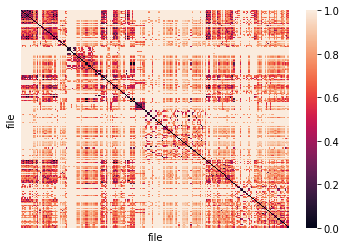

In [7]:
%matplotlib inline
import seaborn as sns

sns.heatmap(
    dissimilarity_df,
    xticklabels=False,
    yticklabels=False
);

Because of the alphabetically ordered filenames and the "feature-first" architecture of the the software under investigation, we get a first glimpse how changes within modules are changed together and which are not.

To get an even better view, we can first extract the module's names with an easy string operation and use this for this indexes.

In [8]:
modules = dissimilarity_df.copy()
modules.index = modules.index.str.split("/").str[6]
modules.index.name = 'module'
modules.columns = modules.index
modules.iloc[25:30,25:30]

module,comment,comment,comment,creator,creator
module,,,,,
comment,0.000000,0.50000,0.750000,0.50000,0.711325
comment,0.500000,0.00000,0.500000,0.00000,0.422650
comment,0.750000,0.50000,0.000000,0.50000,0.711325
creator,0.500000,0.00000,0.500000,0.00000,0.422650
creator,0.711325,0.42265,0.711325,0.42265,0.000000


Then, we can create another heatmap that shows on the name of the modules on the axes for further evaluation. We also just take a look at a subset of the data.

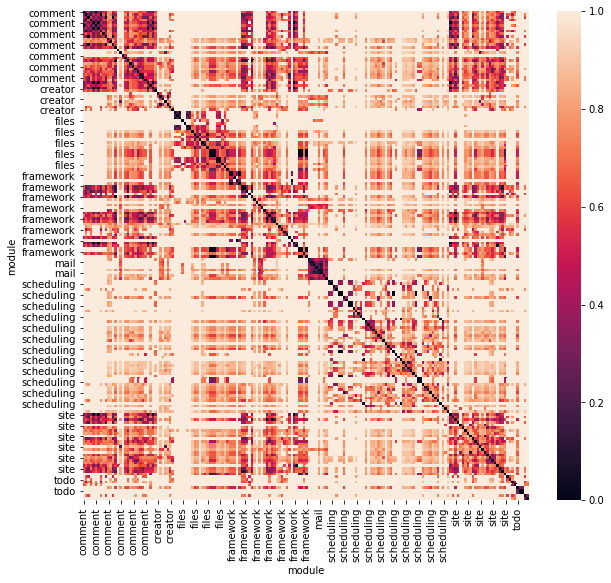

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,9])
sns.heatmap(modules.iloc[:180,:180]);

### Discussion

* Starting at the upper left, we see the "comment" module with a pretty dark area very clearly. This means, that files around this module changed together very often.
* If we go to the middle left, we see dark areas between the "comment" module and the "framework" module as well as the "site" module further down. This shows a change dependency between the "comment" module and the other two (I'll explain later, why it is that way).
* If we take a look in the middle of the heatmap, we see that the very dark area represents changes of the "mail" module. This module was pretty much change without touching any other modules. This shows a nice separation of the responsibility.
* For the "scheduling" module, we can also see that the changes occurred mostly cohesive with the module.

With this visualization, we can get a first impression how good our software architecture fits the real software development activities. In this case, I would say that you can see almost clearly that the source code of the modules change mostly within the module boundaries. But we have to take a look at the changes that occur in other modules as well when changing a particular modules. These could be signs of unwanted dependencies and may lead us to an architectural problem.

## Multi-dimensional scaling
We can create another kind of visualization to check 
* if the code within the modules is only changed all together and
* if not, what other modules were changed. 

Here, we can help ourselves with a technique called ["multi-dimensional scaling"](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html) or "MDS" for short. With MDS, we can break down a n-dimensional space to a lower-dimensional space representation. MDS tries to keep the distance proportions of the higher-dimensional space when breaking it down to a lower-dimensional space.

In our case, we can let MDS figure out a 2D representation of our dissimilarity matrix (which is, overall, just a plain multi-dimensional vector space) to see which files get change together. With this, we'll able to see which files are changes together regardless the modules they belong to.

The machine learning library scikit-learn gives us easy access to the algorithm that we need for this task. We just need to pass the `dissimilarity_df` DataFrame to the `fit_transform` method of the algorithm.

In [10]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=0)
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

array([[-0.5259277 ,  0.45070158],
       [-0.56826041,  0.21528001],
       [-0.52746829,  0.34756761],
       [-0.55856713,  0.26202797],
       [-0.4036568 ,  0.49803657]])

The result is a 2D matrix that we can plot with `matplotlib` to get a first glimpse of the distances.

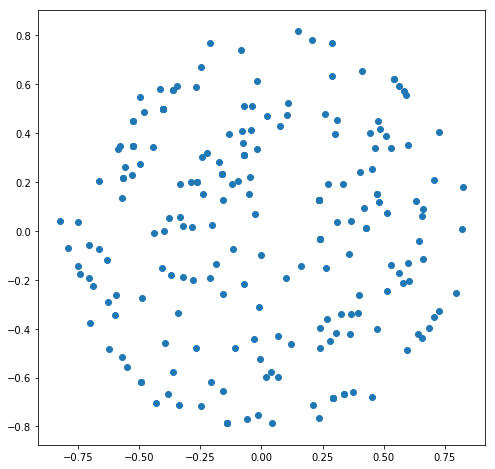

In [11]:
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
plt.scatter(x, y);

With the plot above, we see that the 2D transformation somehow worked. But we can't see
* which filenames are which data points
* how the modules are grouped all together

So we need to enrich the data a little bit more and search for a better, interactive visualization technique.

Let's add the file names to the matrix as well as nice column names. We, again, add the information about the module of a source code file to the DataFrame.

In [12]:
dissimilarity_2d_df = pd.DataFrame(
    dissimilarity_2d,
    index=commit_matrix.index,
    columns=["x", "y"])
dissimilarity_2d_df['module'] = dissimilarity_2d_df.index.str.split("/").str[6]
dissimilarity_2d_df.head()

,x,y,module
file,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,-0.525928,0.450702,comment
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,-0.568260,0.215280,comment
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,-0.527468,0.347568,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,-0.558567,0.262028,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,-0.403657,0.498037,comment


OK, here comes the ugly part: We have to transform all the data to the format our interactive visualization library "pygal" needs. We need to 
* group the data my modules
* add every distance information for each file as well as
* the file name itself 
in a specific dictionary-like data structure.

But there is nothing that can hinder us in Python. So let's do this!

In [13]:
plot_data = pd.DataFrame(index=dissimilarity_2d_df['module'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df['x'], dissimilarity_2d_df['y']))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

module
comment       [{'label': 'backend/src/main/java/at/dropover/...
creator       [{'label': 'backend/src/main/java/at/dropover/...
files         [{'label': 'backend/src/main/java/at/dropover/...
framework     [{'label': 'backend/src/main/java/at/dropover/...
mail          [{'label': 'backend/src/main/java/at/dropover/...
scheduling    [{'label': 'backend/src/main/java/at/dropover/...
site          [{'label': 'backend/src/main/java/at/dropover/...
todo          [{'label': 'backend/src/main/java/at/dropover/...
Name: data, dtype: object

With this nice little data structure, we can fill pygal's XY chart and create [an interactive interactive chart](https://feststelltaste.github.io/software-analytics/notebooks/vis/checking_modularization/dropover.html).

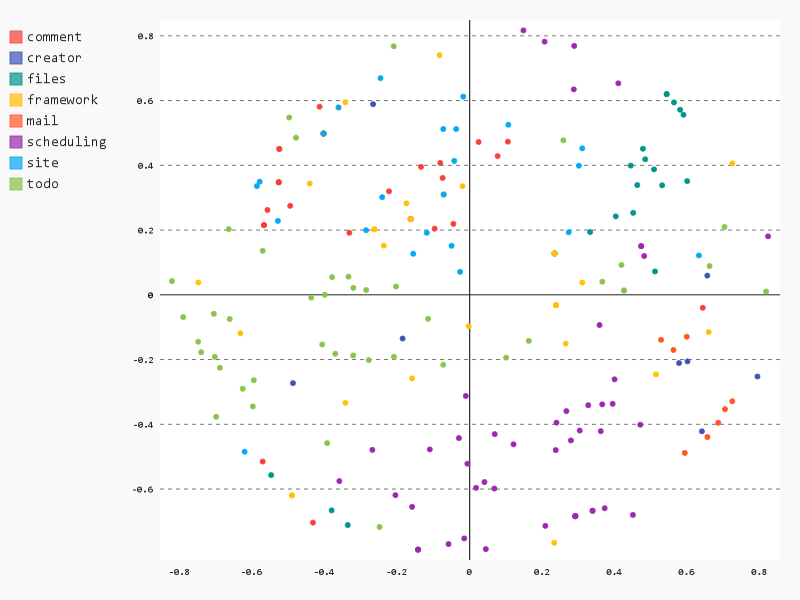

In [14]:
import pygal

xy_chart = pygal.XY(stroke=False)
[xy_chart.add(entry[0], entry[1]) for entry in plot_dict.iteritems()]   
# uncomment to create the interactive chart
# xy_chart.render_in_browser()
xy_chart

This view is a pretty cool way for checking the real change of your software from an architectural perspective. 

### Example
Below, you see the complete data for a data point if you hover over that point:

![](resources/cm_example.png)

What you see here is:
* In the upper left, you find the name of the module in the gray color
* You find the complete name of the source code file in the middle
* You can see the coordinate that MDS assigned to this data point in the color of the selected module

Let's dive even deeper in some insights that we can gain from our result.

### Discussion

#### Module "mail"

![](resources/cm_mail.png)

As already seen in the heatmap, we can see that all files of the "mail" module are very close together. This means that the files change together very often. 

*In the XY chart, we can see this clearly when we hover over the "mail" entry in the legend on the upper left. The corresponding data point will be magnified a little bit.*

#### Module "scheduling"

![](resources/cm_scheduling.png)

Another interesting result can be found if we take a look at the distribution of the files of the module "scheduling". 

*In the XY chart, we can take a look at the relevant data points by selecting just the "scheduling" data points by deselecting all the other entries in the legend.*

#### Modules "comment", "framework" and "site"

![](resources/cm_comment.png)

The last thing I want to show you in our example is the common change pattern for the files of the modules "comment", "framework" and "site". The files of these modules changes together very often, leading to a very mixed colored regions in the upper middle. In case of our project, this is perfectly explainable: These three modules were developed at the beginning of the project. Due to many redesigns and refactorings, those files had to be changed all together. For these modules, it would make sense to only look at the recent development to find out if the code withing these modules is still co-changing.

*In the XY chart, just select the modules "comment", "framework" and "site" to see the details.

# Summary
We've seen how you can check the modularization of your software system by also taking a look at the development activities that's stored in the version control system. This gives you plenty of hints if you've chosen a software architecture that also fits the commit behavior of your development teams.

But there is more: You cannot only check for modularization. You could also e. g. take a look at the commits of your teams, spotting parts that are getting change from too many teams. You could also if your taken actions had any effect by checking only the recent history of the commits.

But for now, we are leaving it here. You can experiment with further options on your own. You can find the complete Jupyter notebook on GitHub.